# Balanced Risk Set Matching

A Python Implementation of the procedures listed in this journal: [Balanced Risk Set Matching by Yunfei Paul Li, Kathleen J Propert & Paul R Rosenbaum](https://www.tandfonline.com/doi/abs/10.1198/016214501753208573)

by Samuel Bonghanoy and Ian de Jesus

### Setup and Data Import

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Read the data
df = pd.read_csv('synthetic_balanced_risk_set_matching.csv')

# Basic data exploration with table format display

# Display Dataset Shape
print("Dataset Shape:")
print(pd.DataFrame([df.shape], columns=["Rows", "Columns"]), "\n")

# Display Column Names
print("Columns:")
print(pd.DataFrame(df.columns.tolist(), columns=["Column Names"]), "\n")

# Display Missing Values
print("Missing Values:")
missing_values = pd.DataFrame(df.isnull().sum(), columns=["Missing Values"])
print(missing_values)

Dataset Shape:
   Rows  Columns
0   400       15 

Columns:
            Column Names
0             Patient_ID
1             Entry_Time
2         Treatment_Time
3          Baseline_Pain
4       Baseline_Urgency
5     Baseline_Frequency
6         Treatment_Pain
7      Treatment_Urgency
8    Treatment_Frequency
9        Outcome_3M_Pain
10    Outcome_3M_Urgency
11  Outcome_3M_Frequency
12       Outcome_6M_Pain
13    Outcome_6M_Urgency
14  Outcome_6M_Frequency 

Missing Values:
                      Missing Values
Patient_ID                         0
Entry_Time                         0
Treatment_Time                   198
Baseline_Pain                      0
Baseline_Urgency                   0
Baseline_Frequency                 0
Treatment_Pain                   198
Treatment_Urgency                198
Treatment_Frequency              198
Outcome_3M_Pain                  198
Outcome_3M_Urgency               198
Outcome_3M_Frequency             198
Outcome_6M_Pain                  198
Outc

### Calculate completion rates

In [3]:
total_patients = len(df)
completed_treatment = df['Treatment_Time'].notna().sum()
completed_3m = df['Outcome_3M_Pain'].notna().sum()
completed_6m = df['Outcome_6M_Pain'].notna().sum()

print("\nCompletion Rates:")
print(f"Started treatment: {total_patients} patients")
print(f"Completed treatment: {completed_treatment} patients ({completed_treatment/total_patients*100:.1f}%)")
print(f"Completed 3-month follow-up: {completed_3m} patients ({completed_3m/total_patients*100:.1f}%)")
print(f"Completed 6-month follow-up: {completed_6m} patients ({completed_6m/total_patients*100:.1f}%)")


Completion Rates:
Started treatment: 400 patients
Completed treatment: 202 patients (50.5%)
Completed 3-month follow-up: 202 patients (50.5%)
Completed 6-month follow-up: 202 patients (50.5%)


### Reshape time series

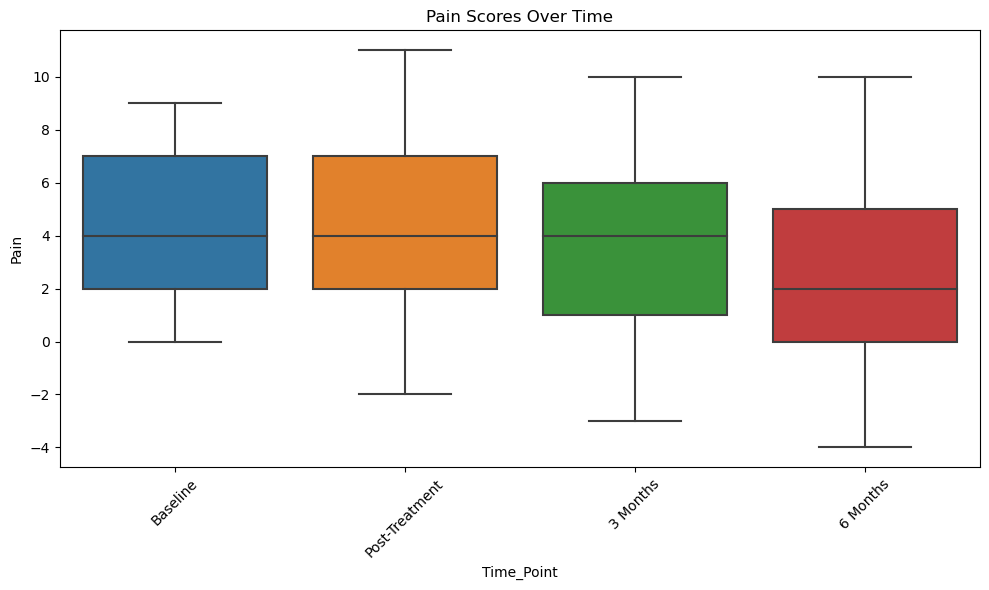

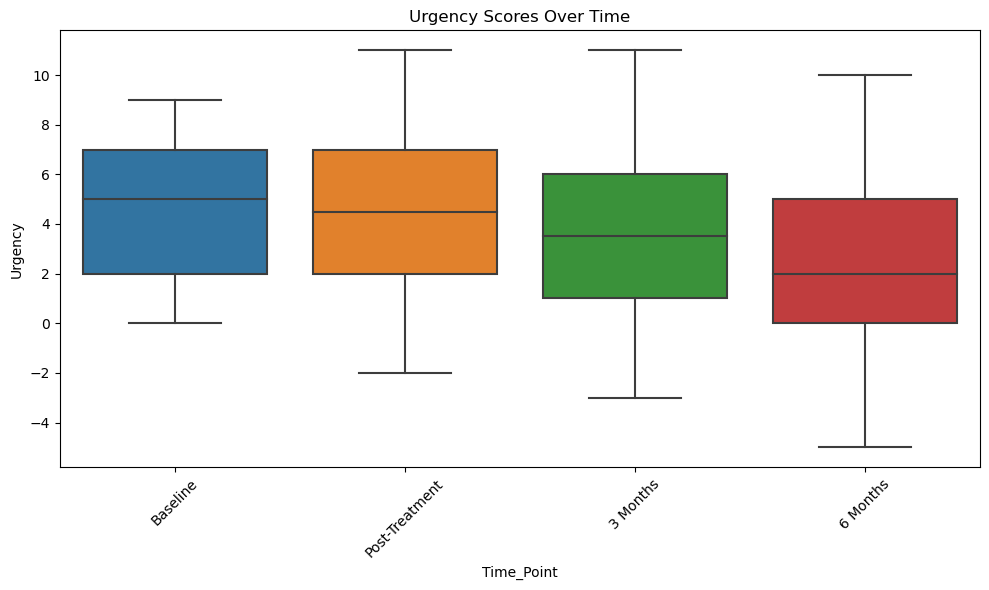

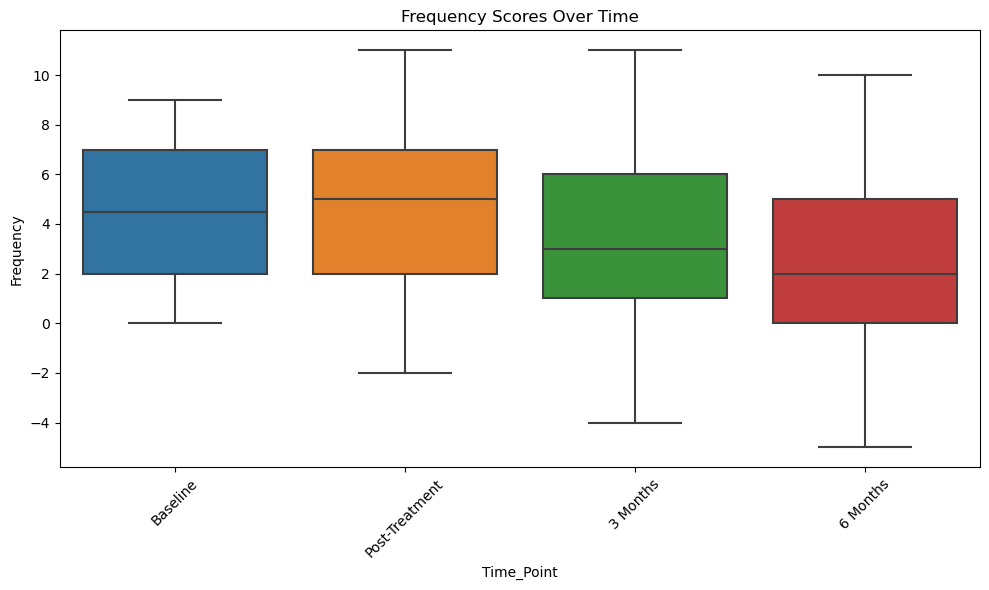

In [3]:
def reshape_time_series(df, symptom):
    columns = [f'Baseline_{symptom}', f'Treatment_{symptom}', 
              f'Outcome_3M_{symptom}', f'Outcome_6M_{symptom}']
    
    long_data = pd.melt(df[['Patient_ID'] + columns], 
                        id_vars=['Patient_ID'],
                        value_vars=columns,
                        var_name='Time_Point',
                        value_name=symptom)
    
    # Clean up time point names
    long_data['Time_Point'] = long_data['Time_Point'].map({
        f'Baseline_{symptom}': 'Baseline',
        f'Treatment_{symptom}': 'Post-Treatment',
        f'Outcome_3M_{symptom}': '3 Months',
        f'Outcome_6M_{symptom}': '6 Months'
    })
    
    return long_data

# Create long format data for each symptom
pain_long = reshape_time_series(df, 'Pain')
urgency_long = reshape_time_series(df, 'Urgency')
frequency_long = reshape_time_series(df, 'Frequency')

# Plotting function
def plot_symptom_overtime(data, symptom):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Time_Point', y=symptom, data=data)
    plt.title(f'{symptom} Scores Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot each symptom over time
plot_symptom_overtime(pain_long, 'Pain')
plot_symptom_overtime(urgency_long, 'Urgency')
plot_symptom_overtime(frequency_long, 'Frequency')

### Perform statistical analysis


Pain Analysis:
+----+--------------------------+---------+
|    | Metric                   |   Value |
+====+==========================+=========+
|  0 | Baseline Mean            |    4.27 |
+----+--------------------------+---------+
|  1 | 6-Month Mean             |    2.26 |
+----+--------------------------+---------+
|  2 | Mean Difference          |    2.01 |
+----+--------------------------+---------+
|  3 | P-Value                  |    0    |
+----+--------------------------+---------+
|  4 | Number of Complete Cases |  202    |
+----+--------------------------+---------+

Urgency Analysis:
+----+--------------------------+---------+
|    | Metric                   |   Value |
+====+==========================+=========+
|  0 | Baseline Mean            |    4.37 |
+----+--------------------------+---------+
|  1 | 6-Month Mean             |    2.45 |
+----+--------------------------+---------+
|  2 | Mean Difference          |    1.92 |
+----+--------------------------+--------

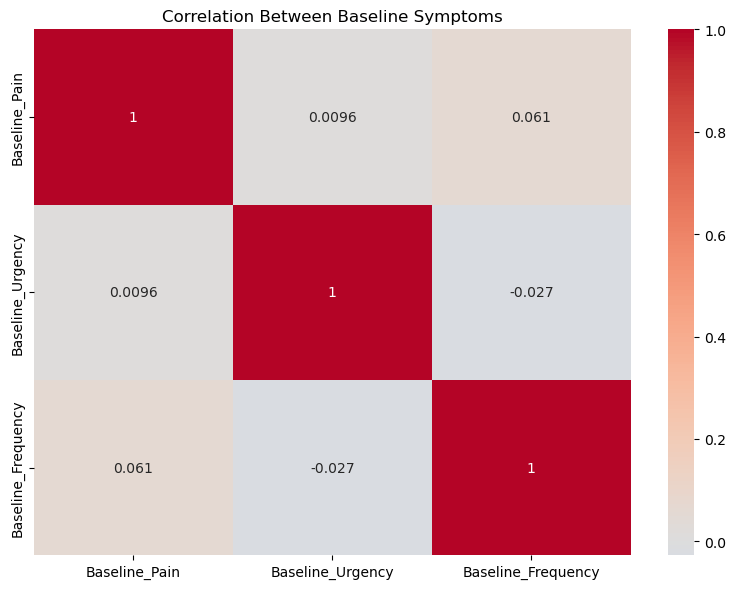


Treatment Time Statistics:
+----+-------------+-----------+
|    | Statistic   |     Value |
+====+=============+===========+
|  0 | count       | 202       |
+----+-------------+-----------+
|  1 | mean        |  17.7475  |
+----+-------------+-----------+
|  2 | std         |   9.72357 |
+----+-------------+-----------+
|  3 | min         |   3       |
+----+-------------+-----------+
|  4 | 25%         |   9       |
+----+-------------+-----------+
|  5 | 50%         |  18       |
+----+-------------+-----------+
|  6 | 75%         |  27       |
+----+-------------+-----------+
|  7 | max         |  33       |
+----+-------------+-----------+


In [5]:
from tabulate import tabulate

def perform_statistical_analysis(df, symptom):
    baseline_col = f'Baseline_{symptom}'
    outcome_col = f'Outcome_6M_{symptom}'
    complete_cases = df[[baseline_col, outcome_col]].dropna()
    
    if len(complete_cases) > 1:
        t_stat, p_value = stats.ttest_rel(complete_cases[baseline_col], complete_cases[outcome_col])
        
        result_df = pd.DataFrame({
            "Metric": ["Baseline Mean", "6-Month Mean", "Mean Difference", "P-Value", "Number of Complete Cases"],
            "Value": [
                f"{complete_cases[baseline_col].mean():.2f}",
                f"{complete_cases[outcome_col].mean():.2f}",
                f"{(complete_cases[baseline_col] - complete_cases[outcome_col]).mean():.2f}",
                f"{p_value:.4f}",
                f"{len(complete_cases)}"
            ]
        })
        print(f"\n{symptom} Analysis:")
        print(tabulate(result_df, headers='keys', tablefmt='grid'))
    else:
        print(f"\nNot enough complete cases for {symptom} analysis")

# Perform statistical analysis for each symptom
perform_statistical_analysis(df, 'Pain')
perform_statistical_analysis(df, 'Urgency')
perform_statistical_analysis(df, 'Frequency')

# Calculate and plot correlation matrix for baseline symptoms
baseline_symptoms = df[[
    'Baseline_Pain', 'Baseline_Urgency', 'Baseline_Frequency'
]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(baseline_symptoms, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Baseline Symptoms')
plt.tight_layout()
plt.show()

# Treatment time analysis
treatment_stats = df['Treatment_Time'].describe().reset_index()
treatment_stats.columns = ["Statistic", "Value"]
print("\nTreatment Time Statistics:")
print(tabulate(treatment_stats, headers='keys', tablefmt='grid'))
